In [1]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

# Moore-Penrose pseudo inverse


In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

Write a function computing the Moore-Penrose pseudo inverse, exploiting the full SVD.


In [3]:
def my_pinv_fullSVD(A):
    U, s, VT = np.linalg.svd(A)
    s[s > 0] = 1 / s[s > 0]
    return VT.transpose() @ la.diagsvd(s, A.shape[1], A.shape[0]) @ U.transpose()

Write now a function computing the Moore-Penrose pseudo inverse, exploiting the reduced SVD.


In [4]:
def my_pinv_thinSVD(A):
    U, s, VT = np.linalg.svd(A, full_matrices=False)
    s[s > 0] = 1 / s[s > 0]
    return VT.transpose() @ np.diag(s) @ U.transpose()

Generate a random matrix $A$ (with elements sampled from a standard Gaussian distribution) with 5 rows and 4 columns. Compute its Moore-Penrose pseudo inverse thorugh the two functions above defined, and compare the result with the function `numpy.linalg.pinv` (see [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html)).


In [5]:
A = np.random.randn(5, 4)
Apinv_numpy = np.linalg.pinv(A)
Apinv_fullSVD = my_pinv_fullSVD(A)
Apinv_thinSVD = my_pinv_thinSVD(A)
print(np.linalg.norm(Apinv_numpy - Apinv_fullSVD) / np.linalg.norm(Apinv_numpy))
print(np.linalg.norm(Apinv_numpy - Apinv_thinSVD) / np.linalg.norm(Apinv_numpy))

7.490288330242873e-17
7.490288330242873e-17


Compare the three implementations performances through the Google Colab magic command `%timeit`.


In [6]:
%timeit np.linalg.pinv(A)

39.2 μs ± 2.45 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%timeit my_pinv_fullSVD(A)

37.7 μs ± 5.69 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%timeit my_pinv_thinSVD(A)

25 μs ± 2.51 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Least-square regression


Consider the linear model

$$
y = mx + q.
$$

where $m = 2$ and $q = 3$.

Generate $N = 100$ points $x_i$, sampling from a standard Gaussian distribution, and the associated $y_i$. Then, add a synthetic noise ($\epsilon_i$) by sampling from a Gaussian distribution with zero mean and standard deviation $\sigma = 2$. Plot the noisy data $(x_i, \tilde{y}_i)$, where $\tilde{y}_i = y_i + \epsilon_i$, in the $(x,y)$ plane, together with the line $y = mx + q$.


In [9]:
m = 2.0
q = 3.0
N = 100
noise = 2.0

X = np.random.randn(N)
Y = m * X + q + noise * np.random.randn(N)

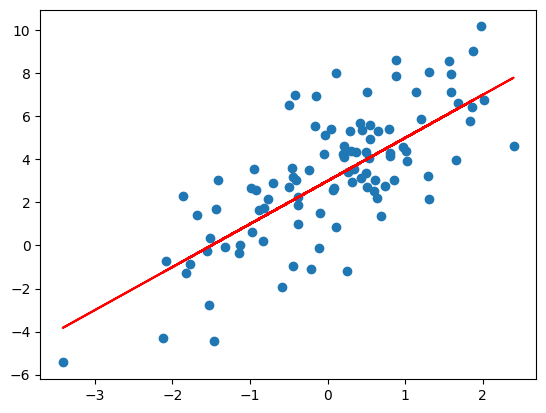

In [10]:
plt.scatter(X, Y)
plt.plot(X, m * X + q, color="red")

Using the previously implemented functions to compute the Moore-Penrose pseudo inverse, solve the least-squares problem

$$
\min_{m,q} \sum_{i=1}^N (\tilde{y}_i - (m x_i + q))^2
$$

and display the regression line superimposed to the noisy data and the exact model.


In [11]:
Phi = np.block([X[:, np.newaxis], np.ones((N, 1))])
z = my_pinv_thinSVD(Phi) @ Y
m_hat = z[0]
q_hat = z[1]
print(f"m_hat = {m_hat:.3f}")
print(f"q_hat = {q_hat:.3f}")

m_hat = 2.045
q_hat = 3.182


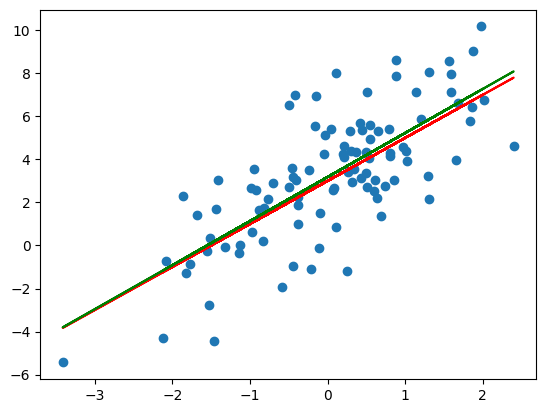

In [12]:
plt.scatter(X, Y)
plt.plot(X, m * X + q, color="red")
plt.plot(X, m_hat * X + q_hat, color="green")

Repeat the excercise by solving the normal equations. Compare the results


In [13]:
z2 = np.linalg.solve(Phi.transpose() @ Phi, Phi.transpose() @ Y)
np.linalg.norm(z - z2)

np.float64(1.7763568394002505e-15)

# Ridge regression and Kernel regression


Consider the function

$$
y = f(x) = \tanh(2x - 1).
$$

Generate $N = 100$ points $x_i$, sampling from a standard Gaussian distribution, and the associated $y_i$. Then, add a synthetic noise ($\epsilon_i$) by sampling from a Gaussian distribution with zero mean and standard deviation $\sigma = 0.1$. Plot the noisy data $(x_i, \tilde{y}_i)$, where $\tilde{y}_i = y_i + \epsilon_i$, in the $(x,y)$ plane.

Then, generate 1000 testing points, uniformly distributed in the interval $[-3,3]$, and display the function $y = f(x)$ in correspondence of the testing points.


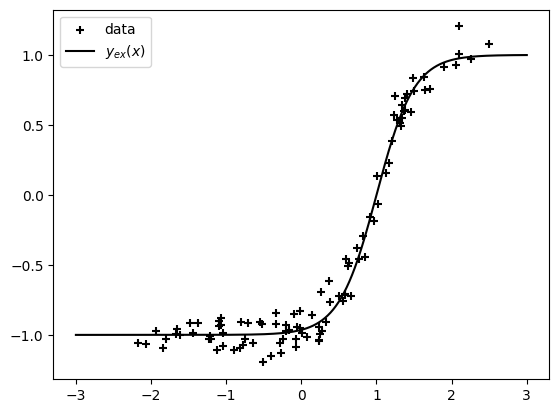

In [14]:
N = 100
noise = 0.1
y_ex = lambda x: np.tanh(2 * (x - 1))

X = np.random.randn(N)
Y = y_ex(X) + noise * np.random.randn(N)

N_test = 1000
X_test = np.linspace(-3, 3, N_test)
Y_test_ex = y_ex(X_test)

plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
plt.legend()

Proceeding as in the previous exercise, compute the regression line resulting from the **least squares regression** of data $(x_i, \tilde{y}_i)$. Plot the resulting regression line.


m_hat = 0.556
q_hat = -0.539


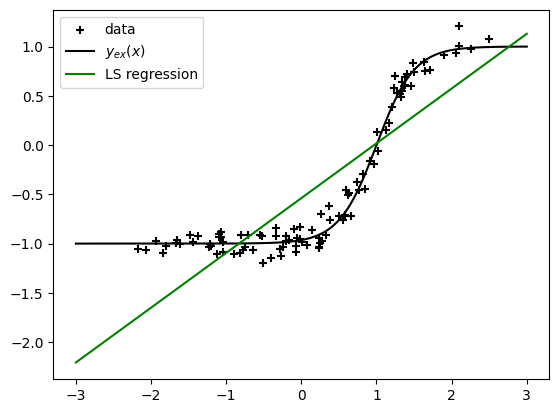

In [15]:
Phi = np.block([X[:, None], np.ones((N, 1))])
z = my_pinv_thinSVD(Phi) @ Y
m_hat = z[0]
q_hat = z[1]
print(f"m_hat = {m_hat:.3f}")
print(f"q_hat = {q_hat:.3f}")
Y_test_LS = m_hat * X_test + q_hat

plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
plt.plot(X_test, Y_test_LS, color="green", label="LS regression")
plt.legend()

Let us now consider **ridge regression**, corresponding to a regularizaton parameter $\lambda = 1.0$. Compare the obtained regression line with the one obtained through least squares regression.


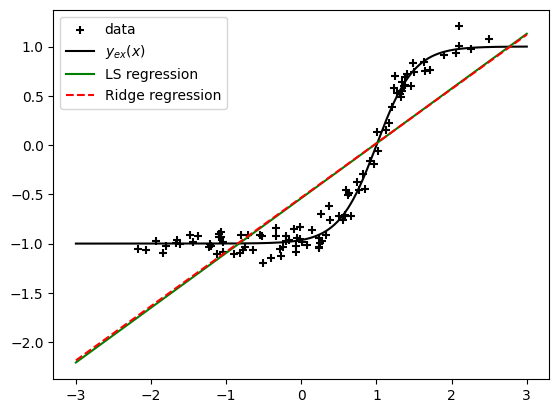

In [16]:
lam = 1.0
PhiPhiT = Phi @ Phi.transpose()
alpha = np.linalg.solve(PhiPhiT + lam * np.eye(N), Y)
w = Phi.transpose() @ alpha
Phi_test = np.block([X_test[:, None], np.ones((N_test, 1))])
Y_test_RR = Phi_test @ w

plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
plt.plot(X_test, Y_test_LS, color="green", label="LS regression")
plt.plot(X_test, Y_test_RR, color="red", linestyle="--", label="Ridge regression")
plt.legend()

Consider now **kernel regression**.

1. Consider first the scalar product kernel
   $$K(x_i,x_j) = x_i x_j + 1.$$
   Compute the regression function and compare the result with the ones obtained at the previous point. How do the results compare?

2. Consider then the higher-order scalar product kernel, for $q > 1$.
   $$K(x_i,x_j) = (x_i x_j + 1)^q.$$

3. Consider finally a Gaussian kernel, for $\sigma > 0$.
   $$K(x_i,x_j) = \exp\left(-\frac{(x_i - x_j)^2}{2 \sigma^2}\right).$$


<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
C:\Users\manse\AppData\Local\Temp\ipykernel_25068\367092889.py:35: SyntaxWarning: invalid escape sequence '\s'
  label=f"Gaussian KR $\sigma = {sigma}$",


(-2.0, 2.0)

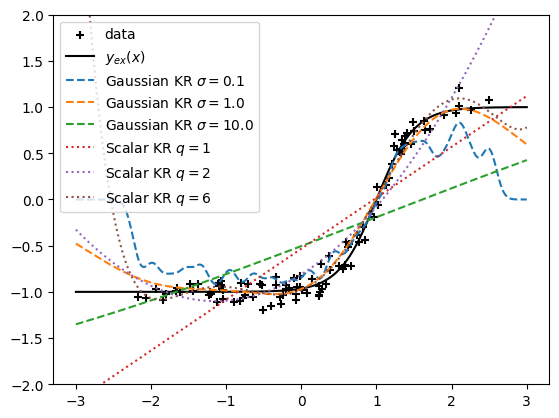

In [17]:
lam = 1.0


def scalar_product_kernel_q(q):
    def scalar_product_kernel(xi, xj):
        return (xi * xj + 1) ** q

    return scalar_product_kernel


def gaussian_kernel_sigma(sigma):
    def gaussian_kernal(xi, xj):
        return np.exp(-np.abs(xi - xj) ** 2 / (2 * sigma**2))

    return gaussian_kernal


def kernel_regression(kernel):
    K = np.array([[kernel(X[i], X[j]) for j in range(N)] for i in range(N)])
    alpha = np.linalg.solve(K + lam * np.eye(N), Y)
    K_test = np.array(
        [[kernel(X_test[i], X[j]) for j in range(N)] for i in range(N_test)]
    )
    Y_test_KR = K_test @ alpha
    return Y_test_KR


plt.scatter(X, Y, marker="+", color="black", label="data")
plt.plot(X_test, Y_test_ex, color="black", label="$y_{ex}(x)$")
for sigma in [0.1, 1.0, 10.]:
    plt.plot(
        X_test,
        kernel_regression(gaussian_kernel_sigma(sigma)),
        linestyle="--",
        label=f"Gaussian KR $\sigma = {sigma}$",
    )
for q in [1, 2, 6]:
    plt.plot(
        X_test,
        kernel_regression(scalar_product_kernel_q(q)),
        linestyle=":",
        label=f"Scalar KR $q = {q}$",
    )
plt.legend()
plt.ylim([-2, 2])